In [69]:
# prerpocessing datasets
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


train_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Train.csv')
test_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Test.csv')


# transform date to datetime type as index
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# set all features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# remove comma
train_df[features] = train_df[features].replace({',': ''}, regex=True).astype(float)
test_df[features] = test_df[features].replace({',': ''}, regex=True).astype(float)


# data normalization, create dataframe for data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])
train_scaled_df = pd.DataFrame(train_scaled, columns=features, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=features, index=test_df.index)

# split train,val sets in 8/2
train_size = int(len(train_scaled_df) * 0.8)
train_data = train_scaled_df[:train_size]
val_data = train_scaled_df[train_size:]

# use past N days to predict next M dayts, create time series
def create_dataset(data, N=30, M=1):
    X, y = [], []
    for i in range(N, len(data) - M + 1):
        X.append(data[i-N:i])  
        y.append(data[i:i+M, 3]) # predict next M days close price
    return np.array(X), np.array(y)
    
X_train, y_train = create_dataset(train_data.values)
X_val, y_val = create_dataset(val_data.values)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (976, 30, 5)
y_train shape: (976, 1)
X_val shape: (222, 30, 5)
y_val shape: (222, 1)


In [33]:
print(test_df.info())
print(f"Scaler data_min: {scaler.data_min_}")
print(f"Scaler data_max: {scaler.data_max_}")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     float64
dtypes: float64(5)
memory usage: 960.0 bytes
None
Scaler data_min: [ 279.12  281.21  277.22  491.2  7900.  ]
Scaler data_max: [8.16680e+02 8.16680e+02 8.05140e+02 1.21683e+03 2.49779e+07]


In [73]:
# Train LSTM model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

# init LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size  
        self.num_layers = num_layers    
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])  # get last time step output
        return out

# set para.
input_size = 5  
hidden_size = 64  
num_layers = 2  
output_size = 1  
num_epochs = 500  
batch_size = 32  
learning_rate = 0.001  

# use dataloader for auto slicing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train
train_losses = []
val_losses = []

# train
for epoch in range(num_epochs):
    model.train()

    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size].unsqueeze(1)  

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)  # MSE loss calculation

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# save model
torch.save(model.state_dict(), 'lstm_model.pth')

In [74]:
# test lstm mse,rmse

model.eval()
with torch.no_grad():

    test_outputs = model(X_val_tensor)
    mse = mean_squared_error(y_val_tensor.cpu(), test_outputs.cpu())
    rmse = math.sqrt(mse)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')


MSE: 0.0002
RMSE: 0.0138


In [41]:
# predict next 30 days, from 1/1 to 1/31 2017, compare with acutal close data

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np


data_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/RealComparedatasets.csv')
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df.set_index('Date', inplace=True)

# only scaler close column, normalizaed 
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data_df[features] = data_df[features].replace({',': ''}, regex=True).astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df[features])
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = close_scaler.fit_transform(data_df[['Close']])
data_df['Scaled_Close'] = scaled_close


N = 30
X_input = scaled_data[-N:].reshape(1, N, len(features))  # reshape to (1, 30, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_input_tensor = torch.Tensor(X_input).to(device)


model.eval()

with torch.no_grad():

    predicted_price = model(X_input_tensor)
    # print(f"Predicted scaled price: {predicted_price}")

    predicted_price = predicted_price.cpu().numpy()
    print(f"Predicted price in numpy array: {predicted_price}")

    # only fill close column
    predicted_price_with_zeros = np.zeros((1, len(features)))
    predicted_price_with_zeros[0, -1] = predicted_price[0, -1]  # only fill close column
    # print(f"Price with zeros for inverse transformation: {predicted_price_with_zeros}")

    # manual denormalization
    close_min = close_scaler.data_min_[0]
    close_max = close_scaler.data_max_[0]
    predicted_close_rescaled = close_min + (predicted_price[0, -1] * (close_max - close_min))
    print(f"Rescaled Close price (manually): {predicted_close_rescaled}")

    print(f"Predicted Close price for 2017-01-01: {predicted_close_rescaled:.2f}")


Predicted price in numpy array: [[0.48674688]]
Rescaled Close price (manually): 772.2232715901732
Predicted Close price for 2017-01-01: 772.22


C:\Users\SpiderJockey\AppData\Local\Temp\ipykernel_22136\3209798552.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_model.pth"))


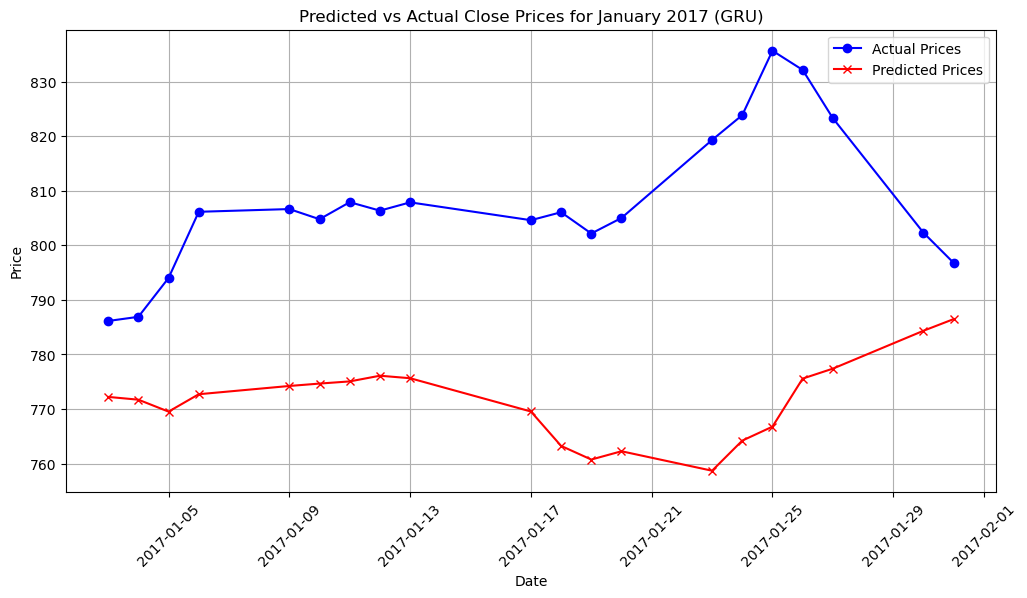

In [75]:
# denormolization data and predict next 30 days

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import matplotlib.pyplot as plt



# model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
# model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()

N = 30
X_input = scaled_data[-N:].reshape(1, N, len(features))  # reshape to (1, 30, 5)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

predicted_prices = []
with torch.no_grad():
    for i in range(31):  
        predicted_price = model(X_input_tensor)  
        predicted_price = predicted_price.cpu().numpy()
        
        # denormalize 
        predicted_close_rescaled = close_scaler.inverse_transform(predicted_price)  
        predicted_prices.append(predicted_close_rescaled[0, 0])  
        
        # update window
        X_input = np.roll(X_input, shift=-1, axis=1)
        X_input[0, -1, -1] = predicted_price[0, -1] 
        X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

test_data = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

# get the actual prices from the test dataset
actual_prices = test_data['Close'].values
actual_dates = test_data.index

predicted_prices_trimmed = predicted_prices[:len(test_data.index)]

# plot
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_prices, label='Actual Prices', color='blue', marker='o')
plt.plot(actual_dates, predicted_prices_trimmed, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Close Prices for January 2017 (GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# create dataframe
results = pd.DataFrame({
    'Date': test_data.index[:len(predicted_prices)],  # Ensure we match the length of predicted prices
    'Predicted Close': predicted_prices[:len(test_data.index)],  # Limit predictions to the length of actual data
    'Actual Close': actual_prices[:len(test_data.index)]  # Use actual closing prices
})

# calculate trend match
results['Trend Match'] = results.apply(
    lambda row: 'Match' if (
        (row['Predicted Close'] > row['Actual Close'] and results.iloc[row.name - 1]['Actual Close'] < row['Actual Close']) or
        (row['Predicted Close'] < row['Actual Close'] and results.iloc[row.name - 1]['Actual Close'] > row['Actual Close'])
    ) else 'Mismatch', axis=1
)


print(results)

matches = results['Trend Match'].value_counts().get('Match', 0)
mismatches = results['Trend Match'].value_counts().get('Mismatch', 0)
total = len(results)
accuracy = (matches / total) * 100

print(f"\nTrend Match Analysis:")
print(f"Total Predictions: {total}")
print(f"Matches: {matches}")
print(f"Mismatches: {mismatches}")
print(f"Trend Match Accuracy: {accuracy:.2f}%")


         Date  Predicted Close  Actual Close Trend Match
0  2017-01-03       772.223267        786.14       Match
1  2017-01-04       771.714417        786.90    Mismatch
2  2017-01-05       769.525696        794.02    Mismatch
3  2017-01-06       772.714539        806.15    Mismatch
4  2017-01-09       774.227295        806.65    Mismatch
5  2017-01-10       774.666748        804.79       Match
6  2017-01-11       775.063782        807.91    Mismatch
7  2017-01-12       776.106445        806.36       Match
8  2017-01-13       775.647705        807.88    Mismatch
9  2017-01-17       769.549377        804.61       Match
10 2017-01-18       763.243774        806.07    Mismatch
11 2017-01-19       760.743408        802.17       Match
12 2017-01-20       762.262512        805.02    Mismatch
13 2017-01-23       758.694641        819.31    Mismatch
14 2017-01-24       764.213928        823.87    Mismatch
15 2017-01-25       766.771973        835.67    Mismatch
16 2017-01-26       775.580872 

In [58]:
# train GRU model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# init GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)  # GRU layer
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out

# set para.
input_size = X_train.shape[2]  # features
hidden_size = 50  # hidden state size
output_size = y_train.shape[1]  
num_layers = 2  # GRU layers
learning_rate = 0.001
num_epochs = 500

# loss function, optimizer
model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# save model
torch.save(model.state_dict(), "gru_model.pth")


Epoch [1/500], Train Loss: 0.0975, Val Loss: 0.0237
Epoch [2/500], Train Loss: 0.0402, Val Loss: 0.0058
Epoch [3/500], Train Loss: 0.0154, Val Loss: 0.0079
Epoch [4/500], Train Loss: 0.0040, Val Loss: 0.0005
Epoch [5/500], Train Loss: 0.0026, Val Loss: 0.0008
Epoch [6/500], Train Loss: 0.0021, Val Loss: 0.0003
Epoch [7/500], Train Loss: 0.0019, Val Loss: 0.0003
Epoch [8/500], Train Loss: 0.0018, Val Loss: 0.0003
Epoch [9/500], Train Loss: 0.0017, Val Loss: 0.0003
Epoch [10/500], Train Loss: 0.0018, Val Loss: 0.0003
Epoch [11/500], Train Loss: 0.0017, Val Loss: 0.0002
Epoch [12/500], Train Loss: 0.0016, Val Loss: 0.0002
Epoch [13/500], Train Loss: 0.0015, Val Loss: 0.0002
Epoch [14/500], Train Loss: 0.0034, Val Loss: 0.0012
Epoch [15/500], Train Loss: 0.0020, Val Loss: 0.0011
Epoch [16/500], Train Loss: 0.0017, Val Loss: 0.0010
Epoch [17/500], Train Loss: 0.0014, Val Loss: 0.0004
Epoch [18/500], Train Loss: 0.0013, Val Loss: 0.0002
Epoch [19/500], Train Loss: 0.0013, Val Loss: 0.0003
Ep

In [59]:
# test accuracy

model.eval()
with torch.no_grad():

    test_outputs = model(X_val_tensor)
    mse = mean_squared_error(y_val_tensor.cpu(), test_outputs.cpu())
    rmse = math.sqrt(mse)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')


MSE: 0.0003
RMSE: 0.0165


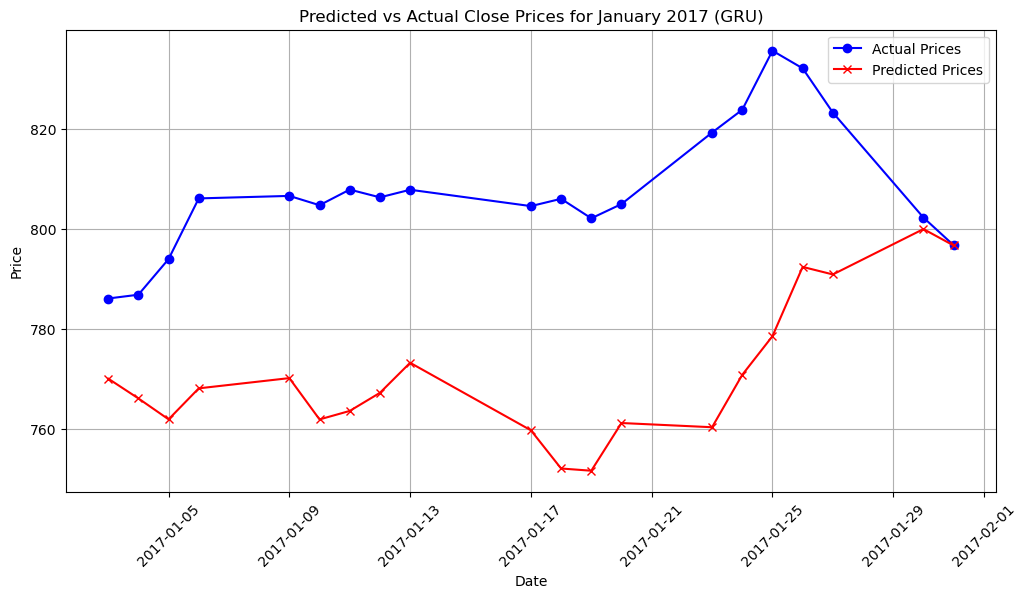

In [60]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


model.eval()

N = 30
X_input = scaled_data[-N:].reshape(1, N, len(features))  # reshape to (1, 30, 5)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

predicted_prices = []
with torch.no_grad():
    for i in range(31):  
        predicted_price = model(X_input_tensor)  
        predicted_price = predicted_price.cpu().numpy()
        
        # denormalize 
        predicted_close_rescaled = close_scaler.inverse_transform(predicted_price)  
        predicted_prices.append(predicted_close_rescaled[0, 0])  
        
        # update window
        X_input = np.roll(X_input, shift=-1, axis=1)
        X_input[0, -1, -1] = predicted_price[0, -1] 
        X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

test_data = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

# Get the actual prices from the test dataset
actual_prices = test_data['Close'].values
actual_dates = test_data.index

# Trim the predicted prices to match the length of actual test data
predicted_prices_trimmed = predicted_prices[:len(test_data.index)]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_prices, label='Actual Prices', color='blue', marker='o')
plt.plot(actual_dates, predicted_prices_trimmed, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Close Prices for January 2017 (GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# create dataframe
results = pd.DataFrame({
    'Date': test_data.index[:len(predicted_prices)],  # Ensure we match the length of predicted prices
    'Predicted Close': predicted_prices[:len(test_data.index)],  # Limit predictions to the length of actual data
    'Actual Close': actual_prices[:len(test_data.index)]  # Use actual closing prices
})

# calculate trend match
results['Trend Match'] = results.apply(
    lambda row: 'Match' if (
        (row['Predicted Close'] > row['Actual Close'] and results.iloc[row.name - 1]['Actual Close'] < row['Actual Close']) or
        (row['Predicted Close'] < row['Actual Close'] and results.iloc[row.name - 1]['Actual Close'] > row['Actual Close'])
    ) else 'Mismatch', axis=1
)


print(results)

matches = results['Trend Match'].value_counts().get('Match', 0)
mismatches = results['Trend Match'].value_counts().get('Mismatch', 0)
total = len(results)
accuracy = (matches / total) * 100

print(f"\nTrend Match Analysis:")
print(f"Total Predictions: {total}")
print(f"Matches: {matches}")
print(f"Mismatches: {mismatches}")
print(f"Trend Match Accuracy: {accuracy:.2f}%")


         Date  Predicted Close  Actual Close Trend Match
0  2017-01-03       770.130798        786.14       Match
1  2017-01-04       766.174316        786.90    Mismatch
2  2017-01-05       761.987793        794.02    Mismatch
3  2017-01-06       768.183655        806.15    Mismatch
4  2017-01-09       770.227966        806.65    Mismatch
5  2017-01-10       761.970032        804.79       Match
6  2017-01-11       763.667236        807.91    Mismatch
7  2017-01-12       767.287170        806.36       Match
8  2017-01-13       773.294495        807.88    Mismatch
9  2017-01-17       759.796448        804.61       Match
10 2017-01-18       752.161072        806.07    Mismatch
11 2017-01-19       751.715942        802.17       Match
12 2017-01-20       761.251099        805.02    Mismatch
13 2017-01-23       760.409851        819.31    Mismatch
14 2017-01-24       770.891357        823.87    Mismatch
15 2017-01-25       778.611511        835.67    Mismatch
16 2017-01-26       792.458374 

In [77]:
# train vanilla RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# init vanilla model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # use the last output
        return out

# Set para.
input_size = len(features)  
hidden_size = 64  
output_size = 1  
epoch = 500
learning_rate = 0.001

# loss function and optimizer
model = VanillaRNN(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)


# train
for e in range(epoch):
    model.train()
    
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 10 == 0:
        print(f"Epoch [{e+1}/{epoch}], Loss: {loss.item():.4f}")

# save model
torch.save(model.state_dict(), 'vanilla_model.pth') 

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    mse = mean_squared_error(y_val_tensor.cpu(), val_outputs.cpu())
    rmse = math.sqrt(mse)

    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')

C:\Users\SpiderJockey\AppData\Local\Temp\ipykernel_22136\1739035404.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vanilla_model.pth")

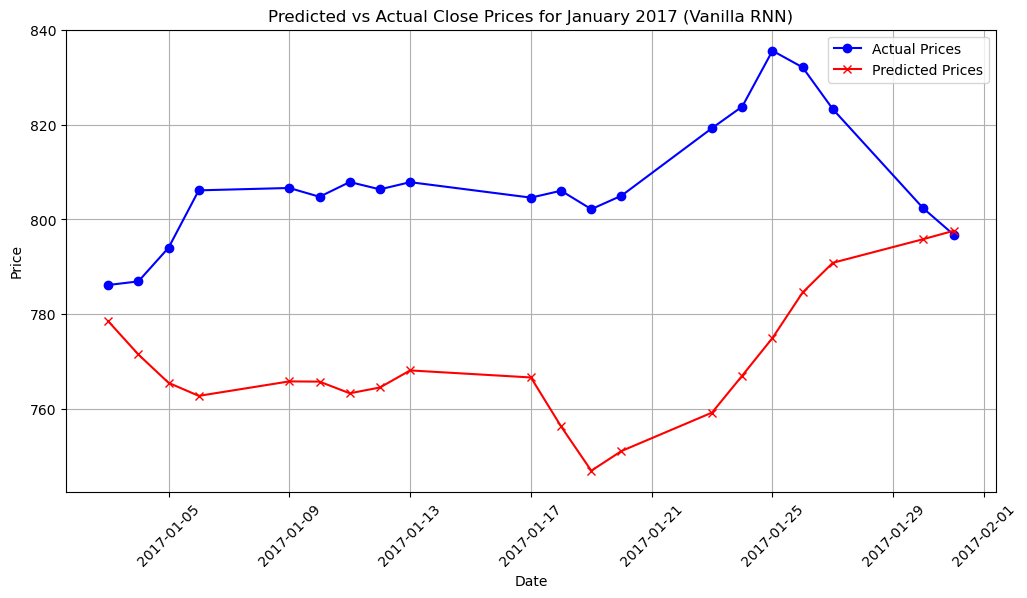

In [78]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
model = VanillaRNN(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load("vanilla_model.pth"))

model.eval()

N = 30
X_input = scaled_data[-N:].reshape(1, N, len(features))  # reshape to (1, 30, 5)

# onvert to tensor
X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

# predict 
predicted_prices = []
with torch.no_grad():
    for i in range(31):  # predict from 1/2 to 1/31
        # predict
        predicted_price = model(X_input_tensor)  
        predicted_price = predicted_price.cpu().numpy()  
        
        # denormolization
        predicted_close_rescaled = close_scaler.inverse_transform(predicted_price)  
        predicted_prices.append(predicted_close_rescaled[0, 0])  
        
        # update window
        X_input = np.roll(X_input, -1, axis=1)  
        X_input[0, -1, -1] = predicted_price[0, -1] 

        # X_input[0, -1, 0:-1] = X_input[0, -2, 0:-1] 
        X_input_tensor = torch.Tensor(X_input).to(device)


# load actual data
test_data = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

actual_prices = test_data['Close'].values
actual_dates = test_data.index

predicted_prices_trimmed = predicted_prices[:len(test_data.index)]

# plot
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_prices, label='Actual Prices', color='blue', marker='o')
plt.plot(actual_dates, predicted_prices_trimmed, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Close Prices for January 2017 (Vanilla RNN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# create dataframe
results = pd.DataFrame({
    'Date': test_data.index[:len(predicted_prices)],  # Ensure we match the length of predicted prices
    'Predicted Close': predicted_prices[:len(test_data.index)],  # Limit predictions to the length of actual data
    'Actual Close': actual_prices[:len(test_data.index)]  # Use actual closing prices
})

# calculate trend match
results['Trend Match'] = results.apply(
    lambda row: 'Match' if (
        (row['Predicted Close'] > row['Actual Close'] and results.iloc[row.name - 1]['Actual Close'] < row['Actual Close']) or
        (row['Predicted Close'] < row['Actual Close'] and results.iloc[row.name - 1]['Actual Close'] > row['Actual Close'])
    ) else 'Mismatch', axis=1
)


print(results)

matches = results['Trend Match'].value_counts().get('Match', 0)
mismatches = results['Trend Match'].value_counts().get('Mismatch', 0)
total = len(results)
accuracy = (matches / total) * 100

print(f"\nTrend Match Analysis:")
print(f"Total Predictions: {total}")
print(f"Matches: {matches}")
print(f"Mismatches: {mismatches}")
print(f"Trend Match Accuracy: {accuracy:.2f}%")


         Date  Predicted Close  Actual Close Trend Match
0  2017-01-03       778.496216        786.14       Match
1  2017-01-04       771.449402        786.90    Mismatch
2  2017-01-05       765.453491        794.02    Mismatch
3  2017-01-06       762.698608        806.15    Mismatch
4  2017-01-09       765.759521        806.65    Mismatch
5  2017-01-10       765.707581        804.79       Match
6  2017-01-11       763.247437        807.91    Mismatch
7  2017-01-12       764.467773        806.36       Match
8  2017-01-13       768.077820        807.88    Mismatch
9  2017-01-17       766.591919        804.61       Match
10 2017-01-18       756.226807        806.07    Mismatch
11 2017-01-19       746.872131        802.17       Match
12 2017-01-20       751.038452        805.02    Mismatch
13 2017-01-23       759.166077        819.31    Mismatch
14 2017-01-24       766.987549        823.87    Mismatch
15 2017-01-25       774.929260        835.67    Mismatch
16 2017-01-26       784.564941 